# Numba example - making a conductive cooling solution quicker



We are interested in the temperature evolution of a rectangular parallelepiped with fixed temperature boundaries that
is cooling by conduction. This needs a solution of the heat equation:
$$
\frac{\partial T}{\partial t}=\alpha\left[\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial y^{2}}+\frac{\partial^{2} T}{\partial z^{2}}\right],
$$
where $\alpha$ is the (constant) thermal diffusivity. The rectangular parallelepiped has dimensions $2 X, 2 Y$ 
and $2 Z$ an initial temperature (at time $t=0$) of $T=T_{\text{in}}$ and a fixed temperature on the boundaties
of $T=T_{\text{ext}}$. We take advantage of an analytical solution for the temperature at some time $t$, and point
$x$, $y$, $z$:
$$
T_{x, y, z, t}=T_{\mathrm{ext}} + (T_{\mathrm{in}}-T_{\mathrm{ext}}) f_{X}(x, t) f_{Y}(y, t) f_{Z}(z, t),
$$
where:
$$
f_{X}(x, t)=\frac{4}{\pi} \sum_{n=0}^{\infty} \frac{(-1)^{n}}{2 n+1} \cos \frac{(2 n+1) \pi x}{2 X} \exp \left(-\frac{(2 n+1)^{2}}{4 X^{2}} \alpha t\right),
$$
and similarly for $f_{Y}(y, t)$ an $f_{Z}(z, t)$.

The `box_cooling` module implements this solution, but we would like to make a 3D plot (say a million points) in 
less time than it takes to make coffee...

In [1]:
import box_cooling

In [2]:
alpha = 0.5 # m^2s^-1
X = 100.0 # m
Y = 100.0 # m
Z = 200.0 # m
Tin = 1000.0 # K
Text = 250.0 # K
print('temperature is:', 
      box_cooling.box_temperature(5000.0, 75.0, 75.0, 75.0, alpha, X, Y, Z, Tin, Text), 'K')

temperature is: 653.3092238629363 K


In [3]:
%%timeit
box_cooling.box_temperature(5000.0, 10.0, 10.0, 10.0, alpha, X, Y, Z, Tin, Text)

6.59 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


that comes to about quarter of an hour to make the plot... 

`box_cooling_jit` has a version that gets compiled by numba:

In [4]:
import box_cooling_jit

In [5]:
%%timeit
box_cooling_jit.box_temperature(5000.0, 10.0, 10.0, 10.0, alpha, X, Y, Z, Tin, Text)

60.1 µs ± 4.05 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note the change of units. This would come to about a minute for the plot.

However, we will still need to call the function for each point and we do not take advantage of the multiple cores on my computer. We can fix both issues in one go with Numba, make the function work like a NumPy "ufunc", and have it run in parallel. `box_cooling_vect` does this: 

In [6]:
import box_cooling_vect

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
%%timeit
box_cooling_vect.box_temperature(np.array([5000.0]), 10.0, 10.0, 10.0, alpha, X, Y, Z, Tin, Text, 1000)

82.2 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
x_range = np.arange(0.0, X, 2)
y_range = np.arange(0.0, Y, 2)
z_range = np.arange(0.0, Z, 2)
x, y, z = np.meshgrid(x_range, y_range, z_range, indexing='ij')
time = 10000.0

In [10]:
%%time
temperature = box_cooling_vect.box_temperature(time, x, y, z, alpha, X, Y, Z, Tin, Text, 1000)
print(temperature.size, 'points calculated')

250000 points calculated
CPU times: user 22.7 s, sys: 84.6 ms, total: 22.8 s
Wall time: 3.01 s


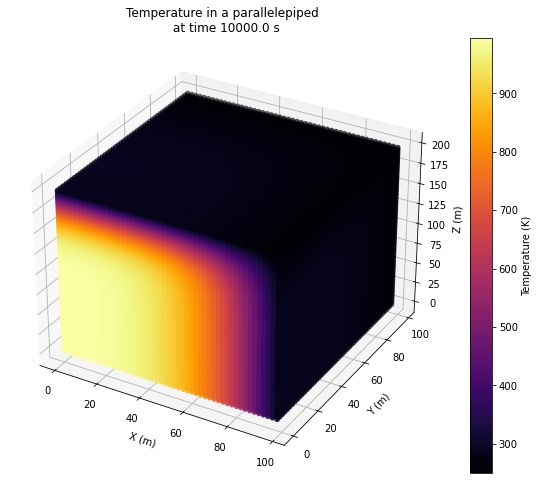

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=temperature.flat, cmap=plt.inferno())
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")

ax.set_title(f"Temperature in a parallelepiped \n at time {time} s")

cb = fig.colorbar(sc)
cb.set_label("Temperature (K)")

plt.show()